# **Deep Convolution Adversarial Networks**

Generative adversarial networks (GANs) are algorithmic architectures that use two neural networks, pitting one against the other (thus the “adversarial”) in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image generation, video generation and voice generation.

GANs are made up of two components -

1. **Generator - generates new data instances**

2. **Discriminator - tries to distinguish the generated or fake data from the real dataset.**

Discriminative algorithms try to classify input data; that is, given the features of an instance of data, they predict a label or category to which that data belongs. So discriminative algorithms map features to labels. They are concerned solely with that correlation.One the other way,loosely speaking,generative algorithms do the opposite. Instead of predicting a label given certain features, they attempt to predict features given a certain label.

While training they both start together from scratch and the generator learn to shape the random distribition through the training epochs.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# **LOSS FUNCTION of simple GAN**

In the paper that introduced GANs(link below in the reference), the generator tries to minimize the following function while the discriminator tries to maximize it:

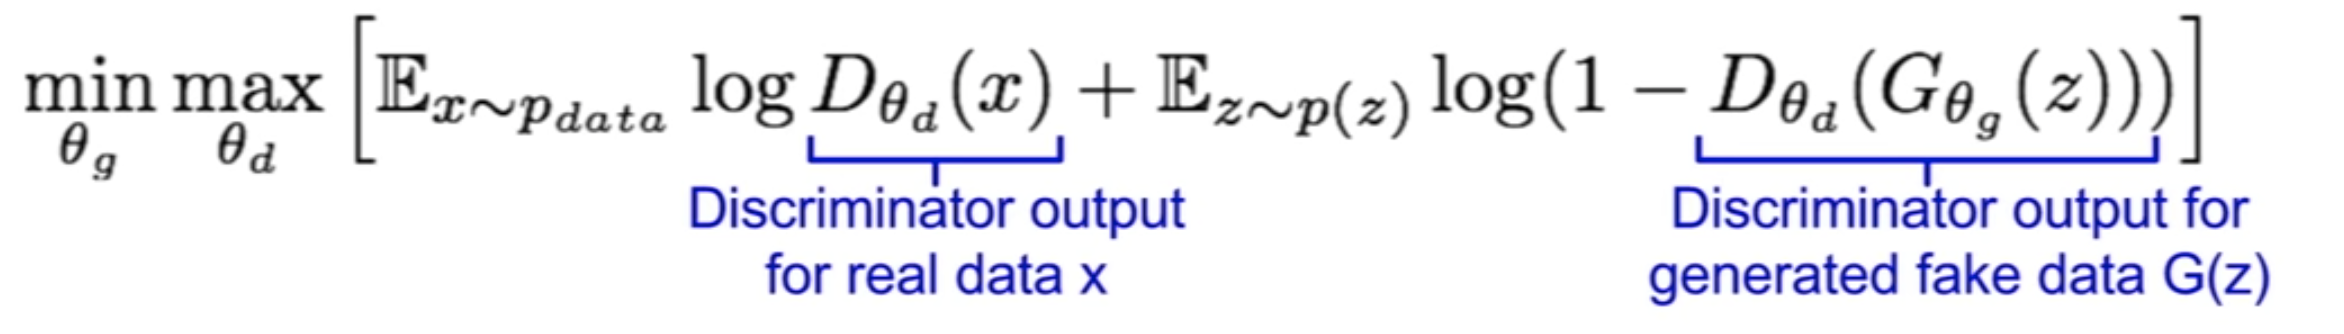

In this function:

D(x) is the discriminator's estimate of the probability that real data instance x is real.

Ex is the expected value over all real data instances.

G(z) is the generator's output when given noise z.

D(G(z)) is the discriminator's estimate of the probability that a fake instance is real.

Ez is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances G(z)).

The generator can't directly affect the log(D(x)) term in the function, so, for the generator, minimizing the loss is equivalent to minimizing log(1 - D(G(z))).

# **Loadind and Preprocessing data**

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf


Using TensorFlow backend.


In [3]:
import os
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir("../input"))

['celeba-dataset']


In [4]:
path_celeb = []
train_path_celeb = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

In [5]:
new_path=path_celeb[0:50000]


the dataset have more than 202k images of which only 50k are being selected for the training purpose

In [ ]:
len(new_path)

In [7]:
crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    #images[i] = images[i]*2-1  #uncomment this if activation is tanh for generator last layer
    
images = np.array(images) 

In [8]:
train_data=images

In [ ]:
print(path_celeb)

In [ ]:
len(path_celeb)

In [ ]:
print(train_data.shape)

# **Data Visualization**

<Figure size 720x720 with 0 Axes>

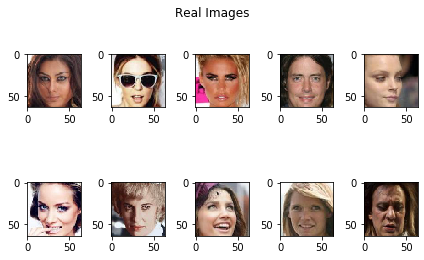

In [59]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=800

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(train_data[idx].reshape(64,64,3))
            #ax[i,j].set_title("Real Image")
            
            idx+=600
            
plt.tight_layout()
plt.show()

**Note**  -- the image pixels are normalized dividing each pixel by 255 and then modified to bring within (-1,1) range by multiplying with 2 and substracting 1 since the last layer activation of generator is tanh whose range limits (-1,1)

In [24]:
X_train = train_data

# **Architecture of the Model**

The core to the DCGAN architecture uses a standard CNN architecture on the discriminative model. For the generator, convolutions are replaced with upconvolutions, so the representation at each layer of the generator is actually successively larger, as it mapes from a low-dimensional latent vector onto a high-dimensional image.



Use batch normalization in both the generator and the discriminator.

Remove fully connected hidden layers for deeper architectures.

Use ReLU activation in generator for all layers except for the output, which uses Tanh.

Use LeakyReLU activation in the discriminator for all layers.

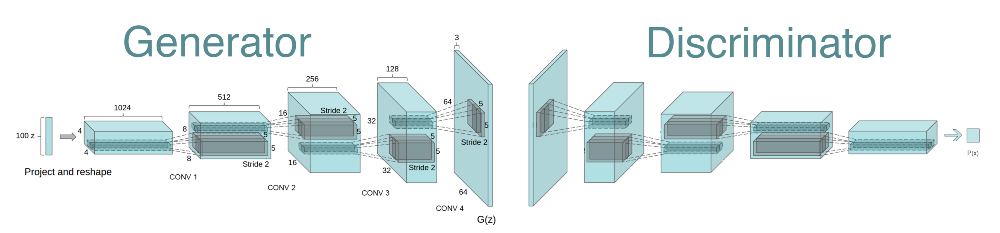

# **Generator**

In [11]:
noise_shape = 100

In [26]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

the last layer for generator  have sigmoid activation in this version since I was trying between sigmoid and tanh to see which outputs better results. I found sigmoid activated model having better clarity in this case, however I have tried tanh activated generator too so if anyone want to refer to that can look at version 6/7 of this kernel where I use tanh. In case of using tanh the input pixels should be normalised between (-1,1) unlike sigmoid where it has been normalised between (0,1) .


In [27]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 128)      

# **Discriminator**

In [28]:
discriminator=Sequential()
discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [29]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 128)        

# **DCGAN (combined model)**

In [30]:
GAN =Sequential([generator,discriminator])

In [31]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [32]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [33]:
GAN.layers

In [20]:
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         3585219   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 695009    
Total params: 4,280,228
Trainable params: 3,584,323
Non-trainable params: 695,905
_________________________________________________________________


# **Training**

In [55]:
epochs = 300  #set epoch according to your training dataset size,i had chosen 50k images hence epochs are high as 300...
batch_size = 128

In [34]:
D_loss=[] #list to collect loss for the discriminator model
G_loss=[] #list to collect loss for generator model

In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")
            
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)
        
        
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
        
         
    if epoch % 5 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

approx training time for 300 epochs was somthing little more than 2 hours.

# **Output Visualization**

In [ ]:
noise=np.random.uniform(-1,1,size=[500,noise_shape])

In [ ]:
im=generator.predict(noise)

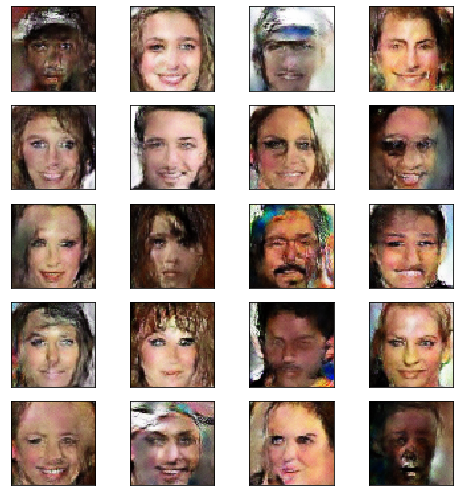

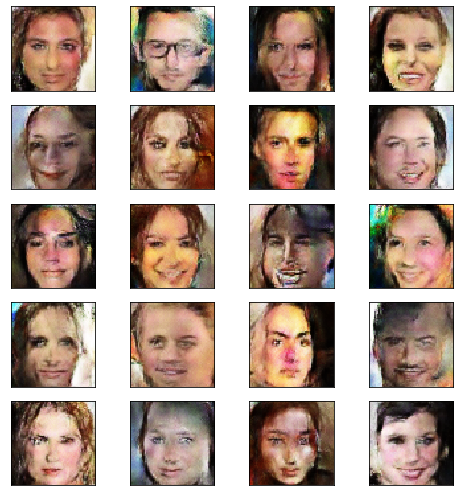

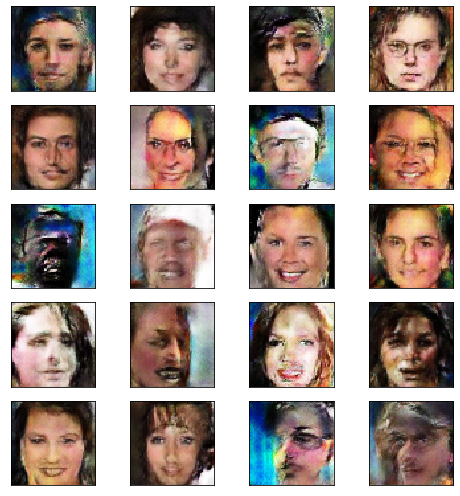

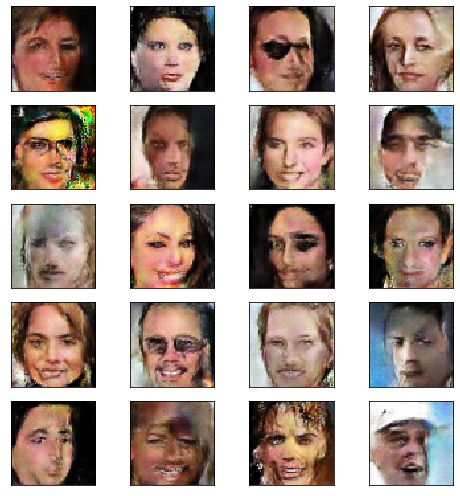

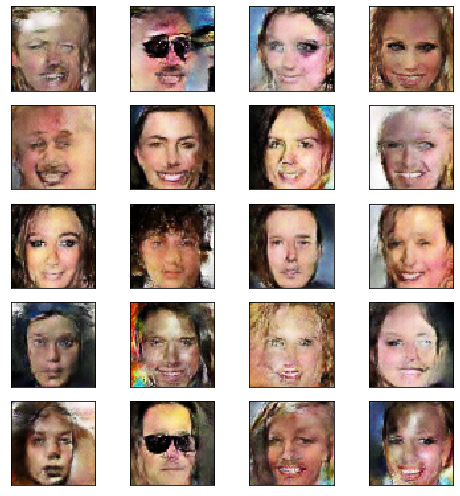

In [68]:
for i in range(5):
 plt.figure(figsize=(7,7))   
 for k in range(20):
            noise=np.random.uniform(-1,1,size=[100,noise_shape])
            im=generator.predict(noise) 
            plt.subplot(5, 4, k+1)
            plt.imshow(im[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
 
 plt.tight_layout()
 plt.show()

# **Loss Curve**

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


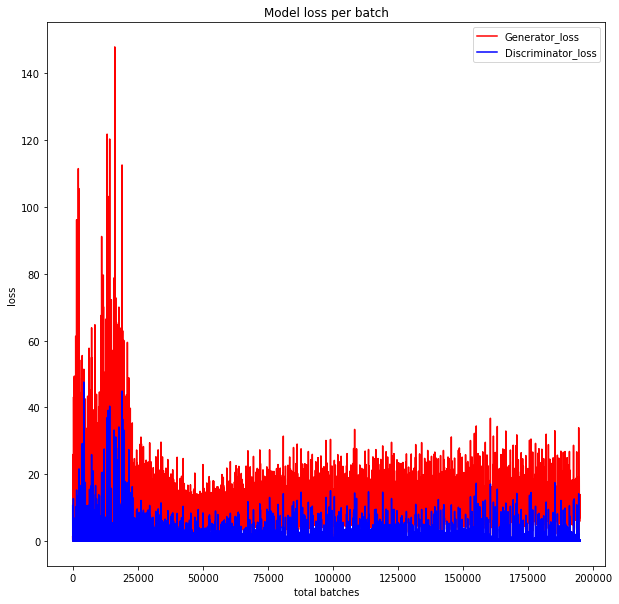

In [69]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

In [70]:
import pickle
Pkl_Filename = "DCGAN.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(GAN, file)

# **Reference**

1. https://medium.com/coloredfeather/generating-human-faces-using-adversarial-network-960863bc1deb blog post
2. https://arxiv.org/abs/1511.06434  paper on DCGANS published in 2016
